### IMPORT E INSTALL

In [ ]:
!pip install pydub
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
import librosa
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy import signal
import gc
from librosa.effects import split
import csv
from google.colab import files
from sklearn.model_selection import train_test_split
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/ProjectDSL/Data/development.csv'
train_audio_path = '/content/drive/MyDrive/ProjectDSL/Data/audios_development'
evaluation_path = '/content/drive/MyDrive/ProjectDSL/Data/evaluation.csv'
eval_audio_path = '/content/drive/MyDrive/ProjectDSL/Data/audios_evaluation'

# DATA ANALYSES

In [ ]:
# Load datasets
df = pd.read_csv(train_path)
df_eval = pd.read_csv(evaluation_path)

In [ ]:
df.info(),df_eval.info(),df.isnull().sum(),df_eval.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      2933 non-null   int64  
 1   sampling_rate           2933 non-null   int64  
 2   age                     2933 non-null   float64
 3   gender                  2933 non-null   object 
 4   ethnicity               2933 non-null   object 
 5   mean_pitch              2933 non-null   float64
 6   max_pitch               2933 non-null   float64
 7   min_pitch               2933 non-null   float64
 8   jitter                  2933 non-null   float64
 9   shimmer                 2933 non-null   float64
 10  energy                  2933 non-null   float64
 11  zcr_mean                2933 non-null   float64
 12  spectral_centroid_mean  2933 non-null   float64
 13  tempo                   2933 non-null   object 
 14  hnr                     2933 non-null   

(None,
 None,
 Id                        0
 sampling_rate             0
 age                       0
 gender                    0
 ethnicity                 0
 mean_pitch                0
 max_pitch                 0
 min_pitch                 0
 jitter                    0
 shimmer                   0
 energy                    0
 zcr_mean                  0
 spectral_centroid_mean    0
 tempo                     0
 hnr                       0
 num_words                 0
 num_characters            0
 num_pauses                0
 silence_duration          0
 path                      0
 dtype: int64,
 Id                        0
 sampling_rate             0
 gender                    0
 ethnicity                 0
 mean_pitch                0
 max_pitch                 0
 min_pitch                 0
 jitter                    0
 shimmer                   0
 energy                    0
 zcr_mean                  0
 spectral_centroid_mean    0
 tempo                     0
 hnr          

There are no null values in the DataFrames. However, there are categorical variables that will be encoded later.


These plots provide insight into the potential accuracy of the prediction.

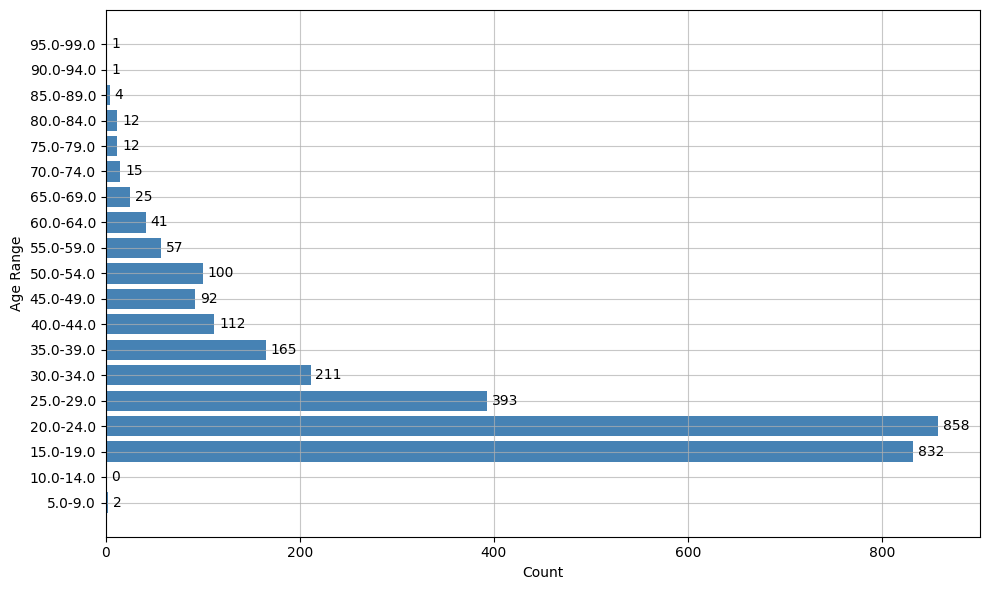

In [ ]:

bins = np.arange(5, df["age"].max() + 6, 5)
labels = [f"{i}-{i+4}" for i in bins[:-1]]


age_ranges = pd.cut(df["age"], bins=bins, labels=labels, right=False, include_lowest=True)


age_range_counts = age_ranges.value_counts().sort_index()


plt.figure(figsize=(10, 6))
bars = plt.barh(age_range_counts.index, age_range_counts.values, color="steelblue")

for bar in bars:
    plt.text(bar.get_width() + 5,
             bar.get_y() + bar.get_height() / 2,
             f"{int(bar.get_width())}",
             va='center', fontsize=10, color='black')

plt.xlabel("Count")
plt.ylabel("Age Range")

plt.grid(axis="x", linestyle="-", alpha=0.7)
plt.grid(axis="y", linestyle="-", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
def get_audio_duration(file_path):
    audio, sr = librosa.load(file_path, sr=None)

    return librosa.get_duration(y=audio, sr=sr)

def add_audio_duration(df, base_path):
    df['duration'] = df['path'].apply(lambda x: get_audio_duration(os.path.join(base_path, x.split("/")[-1])))
    return df

df = add_audio_duration(df, train_audio_path)

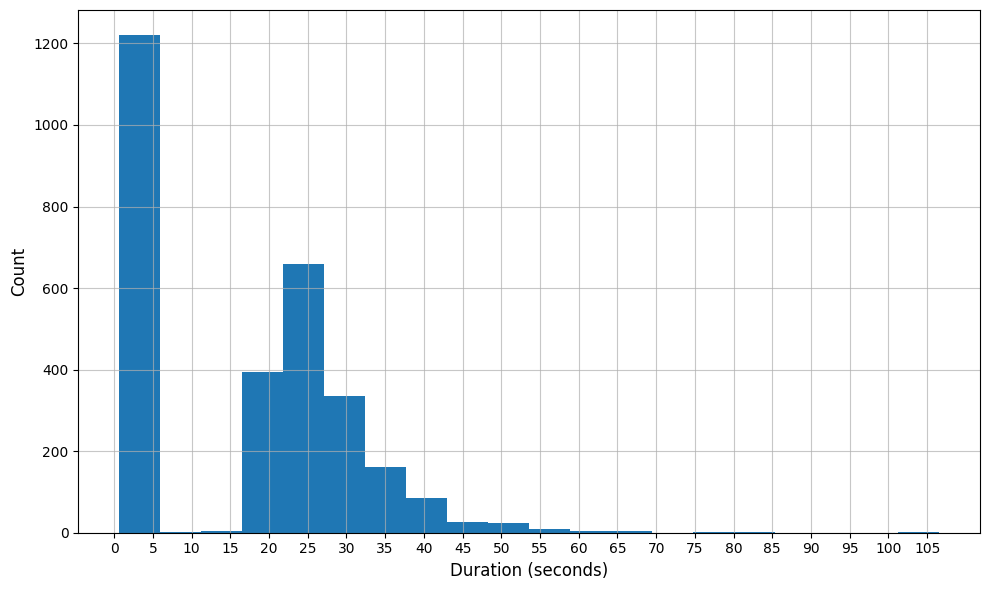

In [ ]:
duration_series = pd.Series(df["duration"])


plt.figure(figsize=(10, 6))
duration_series.plot(kind='hist', bins=20)
plt.xlabel("Duration (seconds)", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.grid(axis="y", linestyle="-", alpha=0.7)
plt.grid(axis="x", linestyle="-", alpha=0.7)


x_ticks = np.arange(0, int(duration_series.max()) + 1, 5)
plt.xticks(x_ticks)

plt.tight_layout()
plt.show()

As we can see from the plots, the predictions will likely be more accurate for younger subjects, particularly those in the 20-25 age range. The durations are concentrated around 5 and 25 seconds. There are some durations greater than 60.

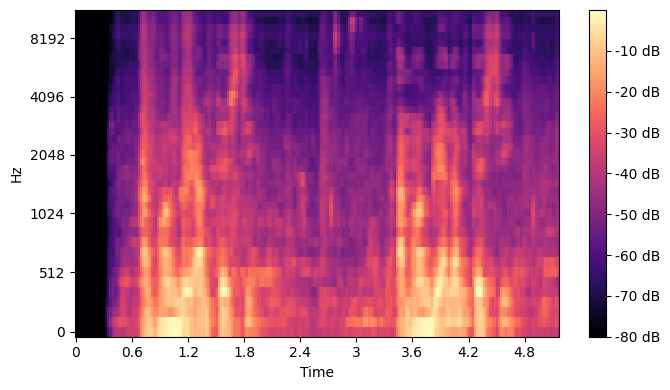

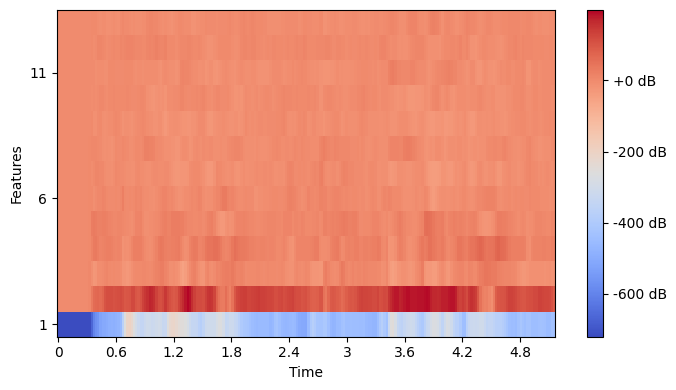

In [ ]:
df = pd.read_csv(train_path)
decima_riga = df.iloc[806]
filename = decima_riga["path"].split("/")[-1]
audio_file = os.path.join(train_audio_path, filename)

try:
    y, sr = librosa.load(audio_file)

    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mels_db = librosa.power_to_db(mels, ref=np.max)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(7, 4))
    librosa.display.specshow(mels_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()

    plt.figure(figsize=(7, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')

    plt.ylabel('Features')
    plt.yticks(np.arange(0, mfccs.shape[0], 5), np.arange(1, mfccs.shape[0] + 1, 5))

    plt.tight_layout()

    plt.show()

except FileNotFoundError:
    print(f"File not found: {audio_file}")
except Exception as e:
    print(f"An error occurred: {e}")


When plotting the Mel spectrogram and MFCCs, the X and Y axes represent different but complementary information:


*   ***Mel Spectrogram***: The X-axis represents time, showing how the audio evolves over time. The Y-axis represents the frequency bands on the Mel scale, which mimics human auditory perception, with narrower bands in lower frequencies and wider bands in higher frequencies.
*   ***MFCCs***: The X-axis also represents time, while the Y-axis shows the MFCC coefficients, which summarize the spectral characteristics of the audio, highlighting elements such as timbre and sound quality.


In both cases, the plots provide a visual representation of how sound evolves over time, with the Mel spectrogram highlighting the spectral distribution and MFCCs condensing the key features into a more compact and targeted representation for tasks like classification.

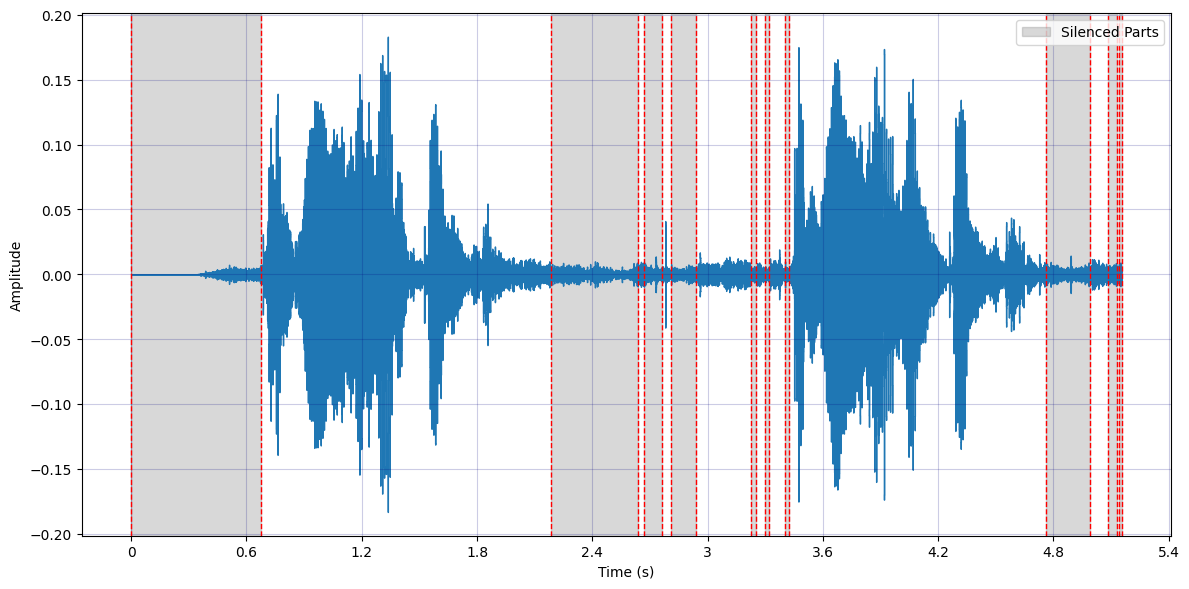

In [ ]:
y, sr = librosa.load(audio_file, sr=None)


non_silent_intervals = librosa.effects.split(y, top_db=25)

total_duration = librosa.get_duration(y=y, sr=sr)

plt.figure(figsize=(12, 6))

librosa.display.waveshow(y, sr=sr)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, color='navy', alpha=0.2)


silent_intervals = []

if non_silent_intervals[0][0] > 0:
    silent_intervals.append([0, non_silent_intervals[0][0]])


for i in range(len(non_silent_intervals) - 1):
    silent_intervals.append([non_silent_intervals[i][1], non_silent_intervals[i + 1][0]])


if non_silent_intervals[-1][1] < len(y):
    silent_intervals.append([non_silent_intervals[-1][1], len(y)])


for start, end in silent_intervals:
    # Gray shading
    plt.axvspan(librosa.samples_to_time(start, sr=sr),
                librosa.samples_to_time(end, sr=sr),
                color='gray', alpha=0.3, zorder=-1)

    # Red lines at the edges
    plt.axvline(librosa.samples_to_time(start, sr=sr), color='red', linestyle='--', linewidth=1)
    plt.axvline(librosa.samples_to_time(end, sr=sr), color='red', linestyle='--', linewidth=1)

plt.axvspan(0, 0, color='gray', alpha=0.3, label="Silenced Parts")

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



The plot for the audio file 807.wav from the development dataset displays both the original and trimmed waveforms. The trimmed waveform has removed all segments where the amplitude is below the 25 dB threshold set by top_db.


*   The ***top_db*** parameter in librosa.effects.trim() sets a decibel threshold for identifying non-silent parts of the audio
*  ***top_db=25***, any segment that is at least 25 dB quieter than the peak amplitude is considered silent and is removed. This helps eliminate low-volume background noise or silence at the start and end of the audio, keeping only the more prominent sounds. In the plot, you can see the difference between the original audio with all silences and the version with silences removed based on the 25 dB threshold.









In [ ]:
df = pd.read_csv(train_path)
decima_riga = df.iloc[806]
filename = decima_riga["path"].split("/")[-1]
audio_file = os.path.join(train_audio_path, filename)



try:
    y, sr = librosa.load(audio_file)

    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
    mels_db = librosa.power_to_db(mels, ref=np.max)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.figure(figsize=(7, 4))
    librosa.display.specshow(mels_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()

    plt.figure(figsize=(7, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')

    plt.ylabel('Features')
    plt.yticks(np.arange(0, mfccs.shape[0], 5), np.arange(1, mfccs.shape[0] + 1, 5))

    plt.tight_layout()

    plt.show()

except FileNotFoundError:
    print(f"File not found: {audio_file}")
except Exception as e:
    print(f"An error occurred: {e}")


When plotting the Mel spectrogram and MFCCs, the X and Y axes represent different but complementary information:


*   ***Mel Spectrogram***: The X-axis represents time, showing how the audio evolves over time. The Y-axis represents the frequency bands on the Mel scale, which mimics human auditory perception, with narrower bands in lower frequencies and wider bands in higher frequencies.
*   ***MFCCs***: The X-axis also represents time, while the Y-axis shows the MFCC coefficients, which summarize the spectral characteristics of the audio, highlighting elements such as timbre and sound quality.


In both cases, the plots provide a visual representation of how sound evolves over time, with the Mel spectrogram highlighting the spectral distribution and MFCCs condensing the key features into a more compact and targeted representation for tasks like classification.

In [ ]:
y, sr = librosa.load(audio_file, sr=None)

non_silent_intervals = librosa.effects.split(y, top_db=25)

total_duration = librosa.get_duration(y=y, sr=sr)

# Create the plot
plt.figure(figsize=(12, 6))

# Original plot
librosa.display.waveshow(y, sr=sr)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, color='navy', alpha=0.2)


silent_intervals = []
if non_silent_intervals[0][0] > 0:
    silent_intervals.append([0, non_silent_intervals[0][0]])

for i in range(len(non_silent_intervals) - 1):
    silent_intervals.append([non_silent_intervals[i][1], non_silent_intervals[i + 1][0]])

if non_silent_intervals[-1][1] < len(y):
    silent_intervals.append([non_silent_intervals[-1][1], len(y)])

for start, end in silent_intervals:
    plt.axvspan(librosa.samples_to_time(start, sr=sr),
                librosa.samples_to_time(end, sr=sr),
                color='gray', alpha=0.3, zorder=-1)

    plt.axvline(librosa.samples_to_time(start, sr=sr), color='red', linestyle='--', linewidth=1)
    plt.axvline(librosa.samples_to_time(end, sr=sr), color='red', linestyle='--', linewidth=1)

plt.axvspan(0, 0, color='gray', alpha=0.3, label="Silenced Parts")
# Display the plots
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



The plot for the audio file 807.wav from the development dataset displays both the original and trimmed waveforms. The trimmed waveform has removed all segments where the amplitude is below the 25 dB threshold set by top_db.


*   The ***top_db*** parameter in librosa.effects.trim() sets a decibel threshold for identifying non-silent parts of the audio
*  ***top_db=25***, any segment that is at least 25 dB quieter than the peak amplitude is considered silent and is removed. This helps eliminate low-volume background noise or silence at the start and end of the audio, keeping only the more prominent sounds. In the plot, you can see the difference between the original audio with all silences and the version with silences removed based on the 25 dB threshold.









# PREPROCESSING

####   PREPROCESSING FUNCTIONS

In [ ]:
import gc  # Garbage collector
import pandas as pd
import numpy as np
import os
import librosa

def extract_audio_features(audio_path):
    try:
        audio_44100, sr_44100 = librosa.load(audio_path, sr=44100)
        non_silent_intervals = librosa.effects.split(audio_44100, top_db=25)  # top_db definisce la soglia per il silenzio
        y_trimmed = np.concatenate([audio_44100[start:end] for start, end in non_silent_intervals])

        time = librosa.times_like(audio_44100, sr=sr_44100)
        duration_trimmed = sum((end - start) for start, end in non_silent_intervals) / sr_44100
        # Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y_trimmed, sr=sr_44100, n_mels=40)
        log_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        features_mel = np.concatenate([
            np.mean(log_spectrogram, axis=1),
            np.std(log_spectrogram, axis=1),
        ])

        delta_features = librosa.feature.delta(log_spectrogram)
        features_speed = np.concatenate([
            np.mean(delta_features, axis=1),
            np.std(delta_features, axis=1),
        ])
        delta_delta_features = librosa.feature.delta(log_spectrogram, order=2)
        features_acceleration = np.concatenate([
            np.mean(delta_delta_features, axis=1),
            np.std(delta_delta_features, axis=1),
        ])

        mfcc = librosa.feature.mfcc(y=audio_44100, sr=sr_44100, n_mfcc=13)
        features_mfcc = np.concatenate([
            np.mean(mfcc, axis=1),
            np.std(mfcc, axis=1),
        ])

        mfcc_speed  = librosa.feature.delta(mfcc)
        features_mfcc_speed = np.concatenate([
            np.mean(mfcc_speed, axis=1),
            np.std(mfcc_speed, axis=1),
        ])
        mfcc_acc = librosa.feature.delta(mfcc, order=2)
        features_mfcc_acceleration = np.concatenate([
            np.mean(mfcc_acc, axis=1),
            np.std(mfcc_acc, axis=1),
        ])
        acf = librosa.autocorrelate(y_trimmed)

        acf_mean = np.mean(acf)
        acf_std = np.std(acf)

        return {
            'mel_features': features_mel,
            'mfcc_features': features_mfcc,
            'speed_features': features_speed,
            'acceleration_features': features_acceleration,
            'mfcc_acc': features_mfcc_acceleration,
            'mfcc_speed':features_mfcc_speed,
            'duration_trimmed': duration_trimmed,
            'acf_mean': acf_mean,
            'acf_std': acf_std

        }

    except Exception as e:
        print(f"Errore durante il processamento di {audio_path}: {e}")
        return None

def create_features_dataframe_in_batches(df, audio_base_path, batch_size):
    calculated_features = []

    def batch_generator(df, batch_size):
        for i in range(0, len(df), batch_size):
            yield df.iloc[i:i + batch_size]

    for batch_df in batch_generator(df, batch_size):
        batch_features = []
        for idx, row in batch_df.iterrows():
            print(f"Sono arrivato alla riga: {row['Id']}")

            # Verifica del percorso
            if 'audios_evaluation' in row['path']:
                audio_path = os.path.join(audio_base_path, row['path'][len('audios_evaluation/'):])
            elif 'audios_development' in row['path']:
                audio_path = os.path.join(audio_base_path, row['path'][len('audios_development/'):])
            else:
                print(f"Percorso non riconosciuto: {row['path']}")
                continue

            # Estrazione delle caratteristiche
            features = extract_audio_features(audio_path)

            if features:
                combined_features = row.to_dict()

                mel_features = features['mel_features']
                half = len(mel_features) // 2
                for i in range(half):
                    combined_features[f'mean_mel_{i+1}'] = mel_features[i]
                    combined_features[f'std_mel_{i+1}'] = mel_features[half + i]

                mfcc_features = features['mfcc_features']
                half = len(mfcc_features) // 2
                for i in range(half):
                    combined_features[f'mean_mfcc_{i+1}'] = mfcc_features[i]
                    combined_features[f'std_mfcc_{i+1}'] = mfcc_features[half + i]

                speed_features = features['speed_features']
                half = len(speed_features) // 2
                for i in range(half):
                    combined_features[f'mean_speed_{i+1}'] = speed_features[i]
                    combined_features[f'std_speed_{i+1}'] = speed_features[half + i]

                acceleration_features = features['acceleration_features']
                half = len(acceleration_features) // 2
                for i in range(half):
                    combined_features[f'mean_acceleration_{i+1}'] = acceleration_features[i]
                    combined_features[f'std_acceleration_{i+1}'] = acceleration_features[half + i]

                mfcc_speed_features = features['mfcc_speed']
                half = len(mfcc_speed_features) // 2
                for i in range(half):
                    combined_features[f'mean_mfcc_speed_{i+1}'] = mfcc_speed_features[i]
                    combined_features[f'std_mfcc_speed{i+1}'] = mfcc_speed_features[half + i]

                mfcc_acc_features = features['mfcc_acc']
                half = len(mfcc_acc_features) // 2
                for i in range(half):
                    combined_features[f'mean_mfcc_acceleration_{i+1}'] = mfcc_acc_features[i]
                    combined_features[f'std_mfcc_acceleration_{i+1}'] = mfcc_acc_features[half + i]

                combined_features['acf_mean'] = features['acf_mean']
                combined_features['acf_std'] = features['acf_std']
                combined_features['duration']= features['duration_trimmed']
                batch_features.append(combined_features)

            del features
            gc.collect()

        calculated_features.extend(batch_features)

        del batch_features
        gc.collect()

    new_df = pd.DataFrame(calculated_features)
    return new_df


In [ ]:
def preprocessing(df, audio_path):
  df['gender'] = df['gender'].replace('famale', 'female')
  label_encoder = LabelEncoder()
  df['tempo'] = df['tempo'].astype(str).str.strip('[]').astype(float)
  df["gender"] = label_encoder.fit_transform(df["gender"])
  df.drop(columns=["ethnicity"], inplace=True)
  final_df = create_features_dataframe_in_batches(df, audio_path, 100)
  final_df.drop(columns=['num_words', 'num_characters', 'num_pauses', "sampling_rate"], inplace=True, errors='ignore')
  return final_df

#### PREPROCESSING INTERFACE


In [ ]:
df_eval = pd.read_csv(evaluation_path)
final_eval_df = preprocessing(df_eval, eval_audio_path)
csv_path = '/content/drive/MyDrive/Data/eval_Saro_features_trimmed_speed_acc_mfcc_acf.csv'
final_eval_df.to_csv(csv_path, index=False)

Sono arrivato alla riga: 0
Sono arrivato alla riga: 1
Sono arrivato alla riga: 2
Sono arrivato alla riga: 3
Sono arrivato alla riga: 4
Sono arrivato alla riga: 5
Sono arrivato alla riga: 6
Sono arrivato alla riga: 7
Sono arrivato alla riga: 8
Sono arrivato alla riga: 9
Sono arrivato alla riga: 10
Sono arrivato alla riga: 11
Sono arrivato alla riga: 12
Sono arrivato alla riga: 13
Sono arrivato alla riga: 14
Sono arrivato alla riga: 15
Sono arrivato alla riga: 16
Sono arrivato alla riga: 17
Sono arrivato alla riga: 18
Sono arrivato alla riga: 19
Sono arrivato alla riga: 20
Sono arrivato alla riga: 21
Sono arrivato alla riga: 22
Sono arrivato alla riga: 23
Sono arrivato alla riga: 24
Sono arrivato alla riga: 25
Sono arrivato alla riga: 26
Sono arrivato alla riga: 27
Sono arrivato alla riga: 28
Sono arrivato alla riga: 29
Sono arrivato alla riga: 30
Sono arrivato alla riga: 31
Sono arrivato alla riga: 32
Sono arrivato alla riga: 33
Sono arrivato alla riga: 34
Sono arrivato alla riga: 35
So

In [ ]:
df_train = pd.read_csv(train_path)
final_train_df = preprocessing(df_train, train_audio_path)
csv_path = '/content/drive/MyDrive/Data/train_Saro_features_trimmed_speed_acc_mfcc_acf.csv'
final_train_df.to_csv(csv_path, index=False)

Sono arrivato alla riga: 0
Sono arrivato alla riga: 1
Sono arrivato alla riga: 2
Sono arrivato alla riga: 3
Sono arrivato alla riga: 4
Sono arrivato alla riga: 5
Sono arrivato alla riga: 6
Sono arrivato alla riga: 7
Sono arrivato alla riga: 8
Sono arrivato alla riga: 9
Sono arrivato alla riga: 10
Sono arrivato alla riga: 11
Sono arrivato alla riga: 12
Sono arrivato alla riga: 13
Sono arrivato alla riga: 14
Sono arrivato alla riga: 15
Sono arrivato alla riga: 16
Sono arrivato alla riga: 17
Sono arrivato alla riga: 18
Sono arrivato alla riga: 19
Sono arrivato alla riga: 20
Sono arrivato alla riga: 21
Sono arrivato alla riga: 22
Sono arrivato alla riga: 23
Sono arrivato alla riga: 24
Sono arrivato alla riga: 25
Sono arrivato alla riga: 26
Sono arrivato alla riga: 27
Sono arrivato alla riga: 28
Sono arrivato alla riga: 29
Sono arrivato alla riga: 30
Sono arrivato alla riga: 31
Sono arrivato alla riga: 32
Sono arrivato alla riga: 33
Sono arrivato alla riga: 34
Sono arrivato alla riga: 35
So

# TRAINING AND TEST

In [ ]:
path_df_train = '/content/drive/MyDrive/ProjectDSL/Data/Dataset_finali/train_Saro_features_trimmed_speed_acc_mfcc_acf.csv'
path_df_eval = '/content/drive/MyDrive/ProjectDSL/Data/Dataset_finali/eval_Saro_features_trimmed_speed_acc_mfcc_acf.csv'

#### TRAINING FUNCTIONS

In [ ]:
def find_best_model(X_train, X_test, y_train, y_test):


    preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

    models = {
        'Random Forest': Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=300, random_state=42))
        ]),

        'Support Vector Regressor': Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('regressor', SVR(kernel='rbf', C= 10.769322731738809, epsilon=0.019314668917207987))
      ])
    }

    rmse_scores = {}
    error_details = {}

    for model_name, model_pipeline in models.items():
        model_pipeline.fit(X_train, y_train)

        y_pred = model_pipeline.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        rmse_scores[model_name] = rmse

        errors = np.abs(y_test - y_pred)

        print(f"{model_name} - RMSE: {rmse}")

    best_model_name = min(rmse_scores, key=rmse_scores.get)
    best_rmse = rmse_scores[best_model_name]

    print(f"\nIl miglior modello è {best_model_name} con RMSE = {best_rmse}")
    return best_model_name, best_rmse, models[best_model_name], rmse_scores


In [ ]:
def run_for_plot(X_train, X_test, y_train, y_test):


    preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

    models = {


        'Support Vector Regressor': Pipeline(steps=[
          ('preprocessor', preprocessor),
          ('regressor', SVR(kernel='rbf', C= 10.769322731738809, epsilon=0.019314668917207987))
      ])
    }

    rmse_scores = {}
    error_details = {}

    for model_name, model_pipeline in models.items():
        model_pipeline.fit(X_train, y_train)

        y_pred = model_pipeline.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        rmse_scores[model_name] = rmse

        errors = np.abs(y_test - y_pred)

        print(f"{model_name} - RMSE: {rmse}")

    best_model_name = min(rmse_scores, key=rmse_scores.get)
    best_rmse = rmse_scores[best_model_name]

    print(f"\nIl miglior modello è {best_model_name} con RMSE = {best_rmse}")
    return best_model_name, best_rmse, models[best_model_name], rmse_scores

In [ ]:
def train(df_path,max_sample_cat):
  df_finale = pd.read_csv(df_path)
  train_df, test_df = train_test_split(df_finale, test_size=0.21, random_state=42)

  bins = range(0, int(train_df['age'].max()) + 2, 2)
  labels = [f"{i}-{i+1}" for i in bins[:-1]]

  train_df['age_group'] = pd.cut(train_df['age'], bins=bins, labels=labels, right=False)
  max_per_category = max_sample_cat

  def limit_samples(group):
      if len(group) > max_per_category:
          return group.sample(max_per_category, random_state=42)
      return group

  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)

  train_df.drop(columns=['age_group'], inplace=True)

  X_train = train_df.loc[:, train_df.columns.difference(['Id', 'path', "age"])]
  y_train = train_df['age']

  X_test = test_df.loc[:, test_df.columns.difference(['Id', 'path', "age"])]
  y_test = test_df['age']

  best_model_name, best_rmse, best_model, rmse_scores = find_best_model(X_train,X_test, y_train, y_test)
  print(f"Miglior modello: {best_model_name}, RMSE: {best_rmse}")

  return best_model, X_train, train_df, test_df, best_rmse, rmse_scores, y_train,X_test,y_test


In [ ]:
def final_eval_process(path, train_model):
  final_eval_df = pd.read_csv(path)
  final_eval_df.drop(columns=['Id', 'path'], inplace=True, errors='ignore')
  train_columns = train_model.columns.tolist()
  eval_columns = final_eval_df.columns.tolist()

  missing_in_eval = set(train_columns) - set(eval_columns)
  extra_in_eval = set(eval_columns) - set(train_columns)

  print("Colonne mancanti in final_eval_df:", missing_in_eval)
  print("Colonne extra in final_eval_df:", extra_in_eval)

  final_eval_df = final_eval_df[train_columns]
  return final_eval_df


In [ ]:
def final_training(best_model,train_df, test_df):
  final_training_df = pd.concat([train_df, test_df])

  X_final = final_training_df.loc[:, final_training_df.columns.difference(['Id', 'path', "age"])]
  y_final = final_training_df['age']

  # Ultimo giro di training con tutti i dati
  best_model.fit(X_final, y_final)

#### TRAINING  AND TEST INTERFACE

In [ ]:
best_model, x_train, train_df, test_df,best_rmse, rmse_scores ,y_train,x_test,y_test = train(path_df_train,150)
eval_df = final_eval_process(path_df_eval, x_train)

In [ ]:
final_training(best_model, train_df, test_df)

In [ ]:
predictions = best_model.predict(eval_df)

# Creare un DataFrame separato per la sottomissione
submission = pd.DataFrame({
    'Id': df_eval['Id'],
    'Predicted': predictions
})

submission = submission.sort_values(by='Id')

# Salvare in un file CSV
submission.to_csv('submission.csv', index=False)

# Scaricare il file
files.download('submission.csv')

# HYPERPARAMETER TUNING

#### FINE TUNING FUNCTIONS

In [ ]:
def optuna_best_model(X_train, X_test, y_train, y_test):

    preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])


    def objective(trial):
        kernel = trial.suggest_categorical("kernel", ["rbf"])
        C = trial.suggest_float("C", 10, 11, log=True)
        epsilon = trial.suggest_float("epsilon", 0.01, 0.02, log=True)

        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', SVR(kernel=kernel, C=C, epsilon=epsilon))
        ])


        score = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
        return score.mean()

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
    print(f"Migliori iperparametri trovati: {best_params}")

    best_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', SVR(
            kernel=best_params["kernel"],
            C=best_params["C"],
            epsilon=best_params["epsilon"]
        ))
    ])

    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"Miglior modello RMSE sul test set: {rmse}")

    return best_model, rmse, best_params

In [ ]:
def grid_search_random_forest(X_train, X_test, y_train, y_test):

    preprocessor = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])


    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])


    param_grid = {
        'regressor__n_estimators': [100, 300],
        'regressor__max_depth': [5, 10, None],
    }

    # Grid Search
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)


    best_params = grid_search.best_params_
    print(f"Migliori parametri trovati: {best_params}")


    best_model = grid_search.best_estimator_


    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"Miglior modello RMSE sul test set: {rmse}")

    return best_model, rmse, best_params

In [ ]:
def find_best_configuration(df_path, max_sample_cat, model_name ):
  df_finale = pd.read_csv(df_path)
  train_df, test_df = train_test_split(df_finale, test_size=0.21, random_state=42)

  bins = range(0, int(train_df['age'].max()) + 2, 2)
  labels = [f"{i}-{i+1}" for i in bins[:-1]]

  train_df['age_group'] = pd.cut(train_df['age'], bins=bins, labels=labels, right=False)
  max_per_category = max_sample_cat

  def limit_samples(group):
      if len(group) > max_per_category:
          return group.sample(max_per_category, random_state=42)
      return group

  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)

  train_df.drop(columns=['age_group'], inplace=True)

  x_train = train_df.loc[:, train_df.columns.difference(['Id', 'path', "age"])]
  y_train = train_df['age']

  x_test = test_df.loc[:, test_df.columns.difference(['Id', 'path', "age"])]
  y_test = test_df['age']
  if model_name == 'SVR':
    return optuna_best_model(x_train, x_test, y_train, y_test)
  if model_name == 'RF':
    return grid_search_random_forest(x_train, x_test, y_train, y_test)

#### FINE TUNING INTERFACE

In [ ]:
best_model, rmse, best_params = find_best_configuration(path_df_train,450, 'RF') # Use SVR or RF

<ipython-input-91-7defa6b3b6c3>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-91-7defa6b3b6c3>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


-----------------------------------------


#PLOT RESULTS

#### PLOTTING FUNCTIONS

In [ ]:
def plot_rmse_by_sample_features(rmse_dict, title):
    plt.figure(figsize=(10, 6))

    for model, values in rmse_dict.items():

        if not values:
            continue

        # Sort values by max_sample_cat
        sorted_values = sorted(values, key=lambda x: x[0])
        sample_values = [n for n, _ in sorted_values]
        rmse_values = [rmse for _, rmse in sorted_values]

        # Create the plot
        plt.plot(sample_values, rmse_values, label=model, marker='o', linestyle='-')

    # Customize the x-axis
    if rmse_dict:
        all_samples = sorted({sample for model_values in rmse_dict.values() for sample, _ in model_values})
        plt.xticks(all_samples)

    plt.xlabel("n")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
def train_feature(df_path,max_sample_cat):

  df_finale = pd.read_csv(df_path)

  # columns removed
  columns_to_drop = ['num_words', 'num_characters', 'num_pauses']
  df_finale = df_finale.drop(columns=columns_to_drop, errors='ignore')
  df_finale['tempo'] = df_finale['tempo'].astype(str).str.strip('[]').astype(float)

  # train and test set
  train_df, test_df = train_test_split(df_finale, test_size=0.21, random_state=42)


  bins = range(0, int(train_df['age'].max()) + 2, 2)
  labels = [f"{i}-{i+1}" for i in bins[:-1]]


  train_df['age_group'] = pd.cut(train_df['age'], bins=bins, labels=labels, right=False)
  max_per_category = max_sample_cat


  def limit_samples(group):
      if len(group) > max_per_category:
          return group.sample(max_per_category, random_state=42)
      return group


  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
  train_df.drop(columns=['age_group'], inplace=True)

  # Final datasets
  X_train = train_df.loc[:, train_df.columns.difference(['Id', "sampling_rate", 'path', "age"])]
  y_train = train_df['age']

  X_test = test_df.loc[:, test_df.columns.difference(['Id', "sampling_rate", 'path', "age"])]
  y_test = test_df['age']


  # Exclude features for "mfcc" configuration
  excluded_features = [feature for feature in df_finale.columns if "mean_speed" in feature or "mean_acceleration" in feature or feature.startswith("acf") or
                       "std_speed" in feature or "std_acceleration" in feature or "mean_mel" in feature or "std_mel" in feature ]

  X_train_mfcc_mel = X_train.drop(columns=excluded_features, errors='ignore')
  X_test_mfcc_mel = X_test.drop(columns=excluded_features, errors='ignore')

  # Train model with original data
  best_model_name_original, best_rmse_original, best_model_original, rmse_scores_original = run_for_plot(X_train, X_test, y_train, y_test)
  print(f"Miglior modello (Original Data): {best_model_name_original}, RMSE: {best_rmse_original}")

  # Train model with excluded features
  best_model_name_mfcc_mel, best_rmse_mfcc_mel, best_model_mfcc_mel, rmse_scores_mfcc_mel = run_for_plot(X_train_mfcc_mel, X_test_mfcc_mel, y_train, y_test)
  print(f"Miglior modello (mfcc + mel): {best_model_name_mfcc_mel}, RMSE: {best_rmse_mfcc_mel}")

  return {
      'original': (best_model_original, X_train, train_df, test_df, best_rmse_original, rmse_scores_original),
      'mfcc': (best_model_mfcc_mel, X_train_mfcc_mel, train_df, test_df, best_rmse_mfcc_mel, rmse_scores_mfcc_mel)
  }


In [ ]:
def obtain_comparison_RF_SVR(max_sample_cat_values):
  rmse_by_sample = {'SVR': [], 'Random Forest': []}


  for max_sample in max_sample_cat_values:
      print(f"Processing max_sample_cat: {max_sample}")
      try:
          best_model, train_model, train_df, test_df, best_rmse, rmse_scores,a,b,c = train(path_df_train, max_sample)
          rmse_by_sample['SVR'].append((max_sample, rmse_scores['Support Vector Regressor']))
          rmse_by_sample['Random Forest'].append((max_sample, rmse_scores['Random Forest']))
      except Exception as e:
          print(f"Error for max_sample_cat = {max_sample}: {e}")

  return rmse_by_sample

Processing max_sample_cat: 140


<ipython-input-4-7d70bb6ac7c4>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-4-7d70bb6ac7c4>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Random Forest - RMSE: 10.211284619103047
Support Vector Regressor - RMSE: 9.16538669409444

Il miglior modello è Support Vector Regressor con RMSE = 9.16538669409444
Miglior modello: Support Vector Regressor, RMSE: 9.16538669409444
Processing max_sample_cat: 150


<ipython-input-4-7d70bb6ac7c4>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-4-7d70bb6ac7c4>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Random Forest - RMSE: 10.124157858284613
Support Vector Regressor - RMSE: 9.14841310628071

Il miglior modello è Support Vector Regressor con RMSE = 9.14841310628071
Miglior modello: Support Vector Regressor, RMSE: 9.14841310628071
Processing max_sample_cat: 160


<ipython-input-4-7d70bb6ac7c4>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-4-7d70bb6ac7c4>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Random Forest - RMSE: 10.12122096449976
Support Vector Regressor - RMSE: 9.152345323588607

Il miglior modello è Support Vector Regressor con RMSE = 9.152345323588607
Miglior modello: Support Vector Regressor, RMSE: 9.152345323588607
Processing max_sample_cat: 170


<ipython-input-4-7d70bb6ac7c4>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-4-7d70bb6ac7c4>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Random Forest - RMSE: 10.036254751331391
Support Vector Regressor - RMSE: 9.157585355898034

Il miglior modello è Support Vector Regressor con RMSE = 9.157585355898034
Miglior modello: Support Vector Regressor, RMSE: 9.157585355898034
Processing max_sample_cat: 180


<ipython-input-4-7d70bb6ac7c4>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-4-7d70bb6ac7c4>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Random Forest - RMSE: 9.868978709994206
Support Vector Regressor - RMSE: 9.143738142483121

Il miglior modello è Support Vector Regressor con RMSE = 9.143738142483121
Miglior modello: Support Vector Regressor, RMSE: 9.143738142483121


In [ ]:
def obtain_mffc_without_spectrogram_and_spectrogram(max_sample_cat_values):
  rmse_by_sample_feature = {'MFCC': [], 'MFCC + Spectrogram': []}
  for max_sample in max_sample_cat_values:
      print(f"Processing max_sample_cat: {max_sample}")
      try:
          # Perform training
          results = train_feature(path_df_train, max_sample)

          # Save RMSE for both configurations
          rmse_by_sample_feature['MFCC'].append((max_sample, results['mfcc'][4]))  # RMSE mfcc_mel
          rmse_by_sample_feature['MFCC + Spectrogram'].append((max_sample, results['original'][4]))  # RMSE original

      except Exception as e:
          print(f"Error for max_sample_cat = {max_sample}: {e}")
  return rmse_by_sample_feature


Processing max_sample_cat: 140


<ipython-input-30-3fcc814496a1>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-30-3fcc814496a1>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Support Vector Regressor - RMSE: 9.176289540559253

Il miglior modello è Support Vector Regressor con RMSE = 9.176289540559253
Miglior modello (Original Data): Support Vector Regressor, RMSE: 9.176289540559253
Support Vector Regressor - RMSE: 9.200756727803439

Il miglior modello è Support Vector Regressor con RMSE = 9.200756727803439
Miglior modello (mfcc + mel): Support Vector Regressor, RMSE: 9.200756727803439
Processing max_sample_cat: 150


<ipython-input-30-3fcc814496a1>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-30-3fcc814496a1>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Support Vector Regressor - RMSE: 9.15552806993754

Il miglior modello è Support Vector Regressor con RMSE = 9.15552806993754
Miglior modello (Original Data): Support Vector Regressor, RMSE: 9.15552806993754
Support Vector Regressor - RMSE: 9.168018982399

Il miglior modello è Support Vector Regressor con RMSE = 9.168018982399
Miglior modello (mfcc + mel): Support Vector Regressor, RMSE: 9.168018982399
Processing max_sample_cat: 160


<ipython-input-30-3fcc814496a1>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-30-3fcc814496a1>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Support Vector Regressor - RMSE: 9.161751585019665

Il miglior modello è Support Vector Regressor con RMSE = 9.161751585019665
Miglior modello (Original Data): Support Vector Regressor, RMSE: 9.161751585019665
Support Vector Regressor - RMSE: 9.1718011507973

Il miglior modello è Support Vector Regressor con RMSE = 9.1718011507973
Miglior modello (mfcc + mel): Support Vector Regressor, RMSE: 9.1718011507973
Processing max_sample_cat: 170


<ipython-input-30-3fcc814496a1>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-30-3fcc814496a1>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Support Vector Regressor - RMSE: 9.168984774095994

Il miglior modello è Support Vector Regressor con RMSE = 9.168984774095994
Miglior modello (Original Data): Support Vector Regressor, RMSE: 9.168984774095994
Support Vector Regressor - RMSE: 9.19798763754292

Il miglior modello è Support Vector Regressor con RMSE = 9.19798763754292
Miglior modello (mfcc + mel): Support Vector Regressor, RMSE: 9.19798763754292
Processing max_sample_cat: 180


<ipython-input-30-3fcc814496a1>:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)
<ipython-input-30-3fcc814496a1>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('age_group', group_keys=False).apply(limit_samples)


Support Vector Regressor - RMSE: 9.157877149026424

Il miglior modello è Support Vector Regressor con RMSE = 9.157877149026424
Miglior modello (Original Data): Support Vector Regressor, RMSE: 9.157877149026424
Support Vector Regressor - RMSE: 9.226352074095827

Il miglior modello è Support Vector Regressor con RMSE = 9.226352074095827
Miglior modello (mfcc + mel): Support Vector Regressor, RMSE: 9.226352074095827


####PLOT INTERFACE

In [ ]:
new_dict = rmse_by_sample.copy()  # Creare una copia del dizionario originale
if 'SVD' in rmse_by_sample:  # Verificare che 'SVD' esista nel dizionario originale
    new_dict['SVR'] = new_dict.pop('SVD')  # Rinominare la chiave
print(new_dict)

{'Random Forest': [(140, 10.211284619103047), (150, 10.124157858284613), (160, 10.12122096449976), (170, 10.036254751331391), (180, 9.868978709994206)], 'SVR': [(140, 9.16538669409444), (150, 9.14841310628071), (160, 9.152345323588607), (170, 9.157585355898034), (180, 9.143738142483121)]}


In [ ]:
# List of max_sample_cat values to consider
max_sample_cat_values = range(140, 181, 10)

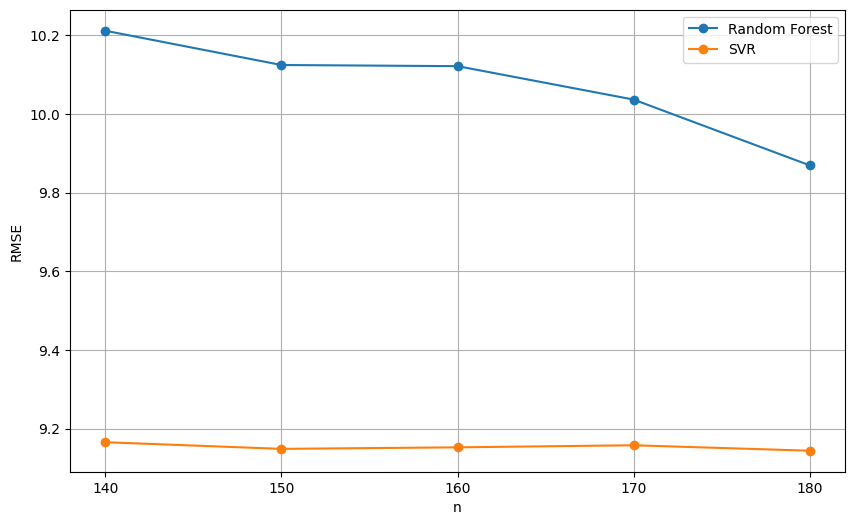

In [ ]:

plot_rmse_by_sample_features(new_dict, "Max Samples per Category")

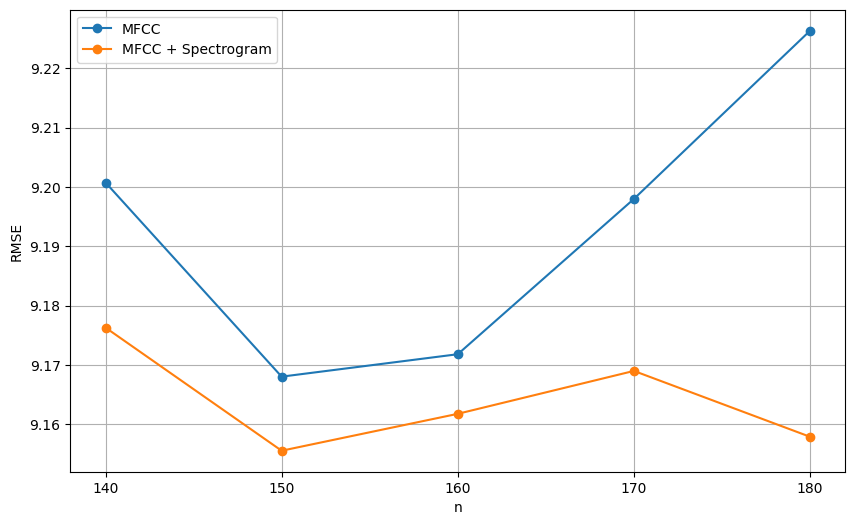

In [ ]:
comparing_dic = obtain_mffc_without_spectrogram_and_spectrogram(max_sample_cat_values)
plot_rmse_by_sample_features(comparing_dic, "Max Samples per Category")